In [60]:
import numpy as np
import pandas as pd
import warnings # 경고 메시지 무시
warnings.filterwarnings(action='ignore')
# 한국어 형태소 분석기 중 성능이 가장 우수한 Mecab 사용
from konlpy.tag import Mecab
mecab = Mecab()
from tqdm import tqdm # 작업 프로세스 시각화
import re # 문자열 처리를 위한 정규표현식 패키지
from gensim import corpora # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
import pyLDAvis # LDA 시각화용 패키지
from collections import Counter # 단어 등장 횟수 카운트
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1. Load Data

data/CBF 폴더에서 정제된 파일들을 불러온다.

In [3]:
vectors = pd.read_json("../../data/CBF/final_tokens_2.json")

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df1 = pd.read_json('../../data/CBF/df_book_clean.json')
df = df1.copy()
df.shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(372, 15)

In [5]:
df2 = pd.read_json('../../data/CBF/article_sum.json')
df2 = df2.copy()
df2.shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3438, 5)

In [6]:
df_des = pd.concat([df['description'],df2['content_tag_removed']])
df_des = pd.concat([df[['name_x','description']].rename(columns={'name_x':'title'}),df2[['title','content_tag_removed']].rename(columns={'content_tag_removed':'description'})], axis=0)
df_des = df_des.reset_index().reset_index().rename(columns={'level_0':'문서 번호'})

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df_des.head()

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,문서 번호,index,title,description
0,0,0,KCD 한방내과 진찰진단 가이드라인,의 번째 큐레이션 상시판매 권승원의 한방내과 진찰진단 가이드라인 의학은빠른속...
1,1,1,우리 아이 감기,우리 아이 감기부제 약물 남용과 과잉치료가 없는 새로운 감기 진료를 목표로 ...
2,2,2,통증치료를 위한 신경초음파와 하이드로다이섹션 테크닉,_ 출판사 리뷰년전 소수 인원이 모여 시작한 통증 공부 모임이 작은 불씨가 ...
3,3,3,의사들이 꼭 알고 있어야 하는 응급의학 실전지침서(1-2),의사들이 꼭 알고 있어야 하는 응급의학 실전지침서
4,4,4,복부 초음파 정석,_ 저자서문 초음파 검사는 임상 영역에서 청진기로 불릴 정도로 간편한...


# 2. Tokenize

형태소 토큰화  
책의 description 과 아티클의 content의 내용을 형태소 분석기를 통해서 명사 추출

형태소 분석기 : Etri API, Mecab 사용  
Mecab을 통해서 명사를 추출하고
Etri API 를 통해서 명사들의 단어사전을 만들어 분석한다.

In [8]:
#################################################################################
from gensim import corpora, models, similarities

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
des_tokenized = []
for doc in tqdm(df_des['description']):
    tokens = [token for token in mecab.nouns(doc) if len(token) > 1] # 각 행(책,아티클)마다의 형태소 분석 명사 추출
    des_tokenized.append(tokens)

len(des_tokenized)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 3810/3810 [00:23<00:00, 164.45it/s]


3810

In [10]:
entri_token = []
for doc in vectors['tokens']:
    entri_token.append(doc)
len(entri_token)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3810

In [11]:
from gensim import corpora
dictionary = corpora.Dictionary(entri_token) # 명사 집합들 사전화
corpus = [dictionary.doc2bow(text) for text in des_tokenized] # 각 문서마다 각 명사의 갯수 분석
print(corpus[0])

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 2), (1, 5), (2, 4), (3, 2), (4, 2), (5, 1), (6, 7), (7, 1), (8, 3), (9, 1), (10, 7), (11, 3), (12, 1), (16, 2), (18, 3), (19, 1), (20, 1), (21, 1), (23, 1), (25, 3), (26, 1), (28, 1), (30, 2), (31, 9), (33, 3), (34, 2), (35, 3), (36, 4), (37, 2), (38, 4), (39, 2), (41, 1), (42, 1), (43, 1), (44, 3), (45, 1), (46, 1), (47, 2), (48, 4), (49, 4), (50, 4), (53, 3), (60, 2), (66, 1), (68, 1), (70, 2), (74, 2), (82, 1), (94, 6), (120, 1), (136, 1), (153, 1), (156, 1), (176, 2), (179, 1), (181, 1), (186, 2), (213, 1), (214, 2), (216, 2), (221, 1), (260, 2), (283, 1), (285, 7), (287, 2), (291, 2), (299, 1), (304, 4), (331, 1), (344, 3), (357, 1), (367, 1), (401, 1), (407, 2), (423, 1), (433, 2), (435, 4), (442, 2), (463, 1), (464, 2), (500, 2), (511, 2), (539, 2), (542, 2), (554, 2), (560, 1), (565, 2), (579, 1), (582, 3), (583, 1), (620, 1), (666, 3), (673, 1), (715, 1), (742, 1), (768, 2), (771, 1), (784, 1), (841, 1), (941, 1), (978, 1), (1013, 1), (1074, 1), (1133, 3), (1140, 1), (117

## 2.1 형태소 사전 분석

In [32]:
# dictionary item 확인
from itertools import islice
def take(n, iterable):
    return list(islice(iterable, n))
items_5 = take(5, dictionary.iteritems())
items_5

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '가이드'), (1, '검사'), (2, '경험'), (3, '교수'), (4, '구성')]

In [33]:
print('Number of unique tokens: %d' % len(dictionary)) # 사전내 유니크한 형태소 수
print('Number of articles: %d' % len(corpus)) 

Number of unique tokens: 14554
Number of articles: 3810


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# description에 나온 사전 속 단어 수
def tokenization_report(bow, article_number):
    # 선택한 문서의 단어 묶음 가져오기
    article_tokens = bow[article_number]
    # 해당 단어 묶음, 출현 빈도에 따라 sort
    sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True)
    
    for i in range(len(bow[article_number])):
        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens[i][0], 
                                                         dictionary[sorted_tokens[i][0]], 
                                                         sorted_tokens[i][1]))
tokenization_report(corpus, 0)

Word 12400 ("한의사") appears 10 time(s).
Word 31 ("임상") appears 9 time(s).
Word 6 ("근거") appears 7 time(s).
Word 10 ("내용") appears 7 time(s).
Word 285 ("시간") appears 7 time(s).
Word 94 ("환자") appears 6 time(s).
Word 1 ("검사") appears 5 time(s).
Word 2 ("경험") appears 4 time(s).
Word 36 ("진료") appears 4 time(s).
Word 38 ("진찰") appears 4 time(s).
Word 48 ("필요") appears 4 time(s).
Word 49 ("하나") appears 4 time(s).
Word 50 ("한방") appears 4 time(s).
Word 304 ("확인") appears 4 time(s).
Word 435 ("한약") appears 4 time(s).
Word 8 ("기록") appears 3 time(s).
Word 11 ("노력") appears 3 time(s).
Word 18 ("배치") appears 3 time(s).
Word 25 ("시행") appears 3 time(s).
Word 33 ("정리") appears 3 time(s).
Word 35 ("진단") appears 3 time(s).
Word 44 ("치료") appears 3 time(s).
Word 53 ("혈액") appears 3 time(s).
Word 344 ("서술") appears 3 time(s).
Word 582 ("직관") appears 3 time(s).
Word 666 ("현장") appears 3 time(s).
Word 1133 ("필자") appears 3 time(s).
Word 3451 ("승원") appears 3 time(s).
Word 0 ("가이드") appears 2 time(s).
Wor

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.2 Mecab과 Etri API 단어 관계

In [35]:
set_tokens_entri = []
for tokens in entri_token:
    for token in tokens:
        set_tokens_entri.append(token)
set_tokens_des = []
for tokens in des_tokenized:
    for token in tokens:
        set_tokens_des.append(token)



/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# 원래 단어사전에 포함된 단어 갯수
len(dictionary)

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14554

### Mecab에서 단어 분류는 되었지만 etri 단어사전에 포함안된 단어들

In [37]:
print(f'Mecab에만 포함된 단어 갯수(Etri와 함께 사용하면서 빠진 단어들) : {len(set(set_tokens_des) - set(set_tokens_entri))}개,\n예시 : {list(set(set_tokens_des) - set(set_tokens_entri))[:20]}')


Mecab에만 포함된 단어 갯수(Etri와 함께 사용하면서 빠진 단어들) : 27071개,
예시 : ['아키', '서영대', '현격', '신개', '天壽', '구개골', '수개월', '吐劑', '한창호', '뒷벽', '육물', '관리국', '多飮', '因時', '물류', '산업체', '뉴클레오티드', '차액', '북미', '장문합술']


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### etri 단어사전에는 등록되었지만 Mecab에서 단어 분류가 안된 단어들

In [38]:
print(f'Etri에만 포함된 단어 갯수(Mecab과 함께 사용하면서 빠진 단어들) : {len(set(set_tokens_entri) - set(set_tokens_des))}개,\n예시 : {list(set(set_tokens_entri) - set(set_tokens_des))[:20]}')


Etri에만 포함된 단어 갯수(Mecab과 함께 사용하면서 빠진 단어들) : 5529개,
예시 : ['날감기', '타촉', '세요', '치료프롤', '정신과적', '반하국', '오렌지라이프', '디스크구', '을예', '가쪽가슴동', '급성상', '성직', '담도담', '설사물', '비뚤림', '무채', '애연', '침술이', '경방임', '제늑골']


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 실제 단어사전에서 사용된 단어 갯수

In [39]:
len(set(set_tokens_entri)) - len(set(set_tokens_entri) - set(set_tokens_des))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9025

### 결론 : etri와 Mecab을 같이 사용함으로써 더 정제된 단어사전을 쉽고 빠르게 만들 수 있었다.

# 3. LDA 
CBF 유사한 아이템을 찾는 방법으로 토픽 모델링을 이용하기로 결정하였다.

토픽 모델링 방법 중 비교적 자유도가 있고, 도메인을 덜타는 Gensim 라이브러리의 LDA를 사용하여 모델링

## 3.1 LDA - Determining Optimal Topic Number

In [62]:
import os
topicnums = [1,5,10,15,20,25,30,35,40,45,50]
project_folder = '../../data/CBF/'

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    if not os.path.exists(project_folder+'/models6/ldamodels_bow_'+str(i)+'.lda'):
        %time ldamodels_bow[i] = models.LdaModel(corpus, num_topics=i, random_state=42, update_every=1, passes=10, id2word=dictionary,minimum_probability=0.01)
        ldamodels_bow[i].save(project_folder+'/models6/ldamodels_bow_'+str(i)+'.lda')
        print('ldamodels_bow_{}.lda created.'.format(i))
    else: 
        print('ldamodels_bow_{}.lda already exists.'.format(i))

ldamodels_bow_1.lda already exists.
ldamodels_bow_5.lda already exists.
ldamodels_bow_10.lda already exists.
ldamodels_bow_15.lda already exists.
ldamodels_bow_20.lda already exists.
ldamodels_bow_25.lda already exists.
ldamodels_bow_30.lda already exists.
ldamodels_bow_35.lda already exists.
ldamodels_bow_40.lda already exists.
ldamodels_bow_45.lda already exists.
ldamodels_bow_50.lda already exists.


In [63]:
import pickle
lda_topics = {}
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models6/ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    #'0.037*"치료" + 0.022*"신경" + 0.021*"시술" + 0.018*"경우" + 0.017*"환자" + 0.016*"손상" + 0.016*"골절" + 0.016*"약침" + 0.015*"통증" + 0.012*"도침"'
    # 위 내용 정리
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open(project_folder+'/models6/pub_lda_bow_topics.pkl','wb'))

## coherences, perplexities

|--|Perplexity|Topic Coherence|
|--|--|--|
|의미|확률 모델이 결과를 얼마나 정확하게 예측하는지.낮을수록 정확하게 예측.|토픽이 얼마나 의미론적으로 일관성 있는지.높을수록 의미론적 일관성 높음|
|주용도|동일 모델 내 파라미터에 따른 성능 평가할 때 주로 사용|해당 모델이 얼마나 실제로 의미있는 결과를 내는지|
|한계|Perplexity가 낮다고 해서, 결과가 해석 용이하다는 의미가 아님|평가를 진행하기 위해 다른 외부 데이터(코퍼스, 시소러스 등)가 필요|

In [64]:
coherences=[]
perplexities=[]
passes=[]
for i in topicnums:
    lda_model = models.LdaModel.load(project_folder+'/models6/ldamodels_bow_'+str(i)+'.lda')
    cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()

    coherences.append(coherence)
    perplexities.append(lda_model.log_perplexity(corpus))
    print("Cpherence",coherence)
    print('Perplexity: ', lda_model.log_perplexity(corpus),'\n\n')
    

Cpherence -0.7146464438417615
Perplexity:  -7.442251313917082 


Cpherence -1.0015728516701246
Perplexity:  -7.117507762310223 


Cpherence -1.2576459628826446
Perplexity:  -7.039066387594315 


Cpherence -1.441573831733796
Perplexity:  -7.048779440017253 


Cpherence -1.5192425681117254
Perplexity:  -7.054411050164184 


Cpherence -1.7034844311916586
Perplexity:  -7.054572381240857 


Cpherence -1.7733919558303095
Perplexity:  -7.06114711328682 


Cpherence -1.5757846233353245
Perplexity:  -7.079992430443916 


Cpherence -1.7667201893098703
Perplexity:  -7.085316368703548 


Cpherence -1.7851524942873391
Perplexity:  -7.108022267386553 


Cpherence -2.1267770700805086
Perplexity:  -7.131362965585505 




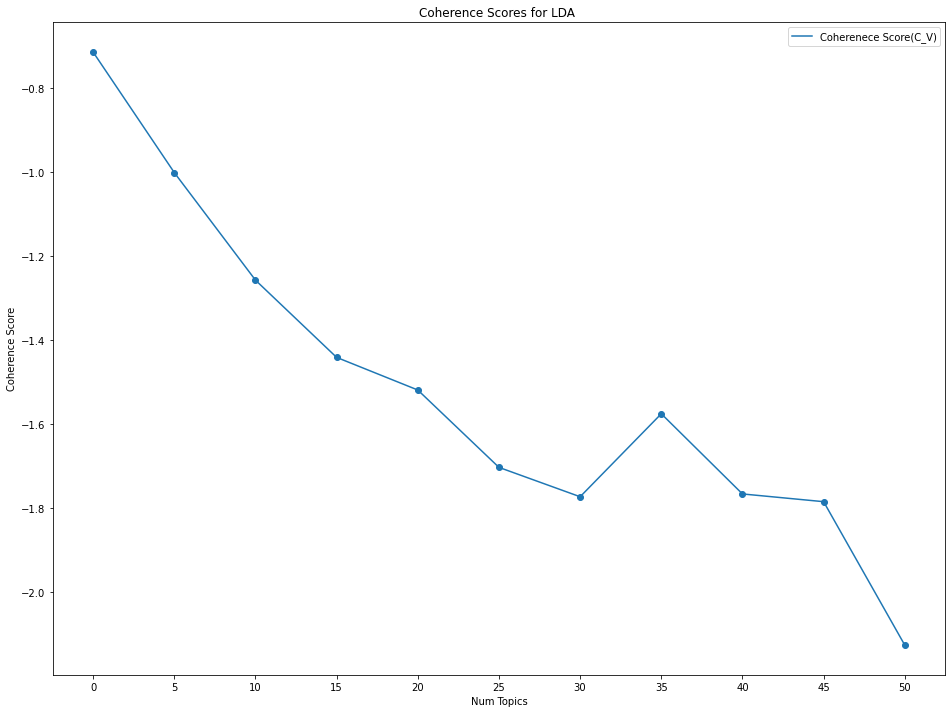

In [65]:
coherence_list = coherences
label = "Coherenece Score(C_V)"

x = range(0, 51, 5)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, coherence_list, label=label)
plt.scatter(x, coherence_list)
plt.title(f"Coherence Scores for LDA ")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(loc='best')
plt.show()

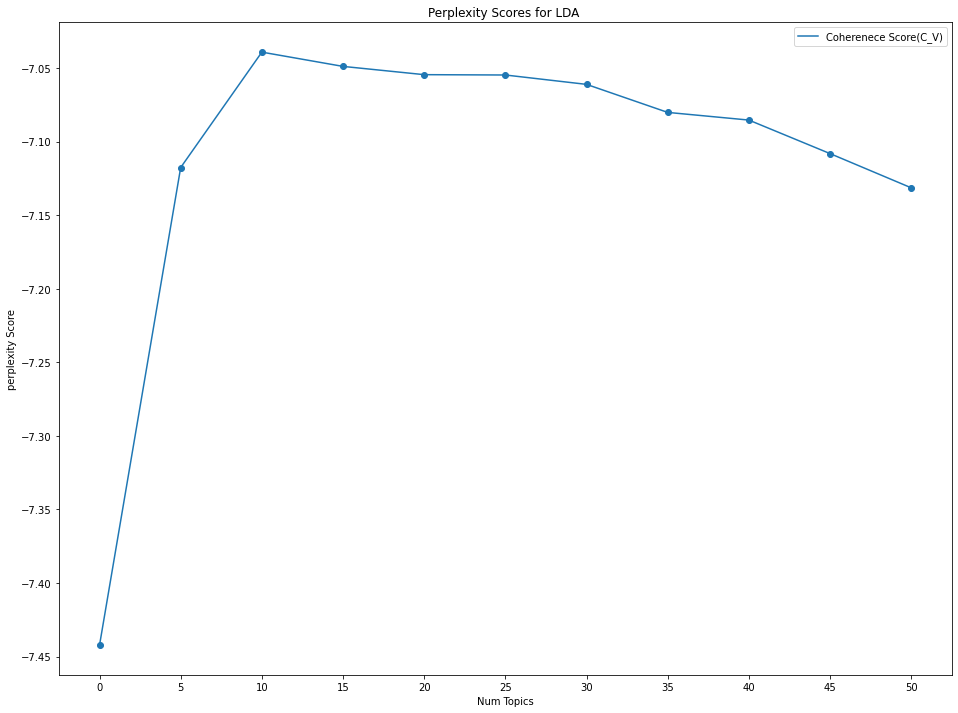

In [66]:
perplexity_list = perplexities
label = "Coherenece Score(C_V)"

x = range(0, 51, 5)
plt.figure(figsize=(16, 12))
plt.xticks(x)
plt.plot(x, perplexity_list, label=label)
plt.scatter(x, perplexity_list)
plt.title(f"Perplexity Scores for LDA ")
plt.xlabel("Num Topics")
plt.ylabel("perplexity Score")
plt.legend(loc='best')
plt.show()

## 자카드 유사도

In [45]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open(project_folder+'/models6/pub_lda_bow_stability.pkl','wb'))

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


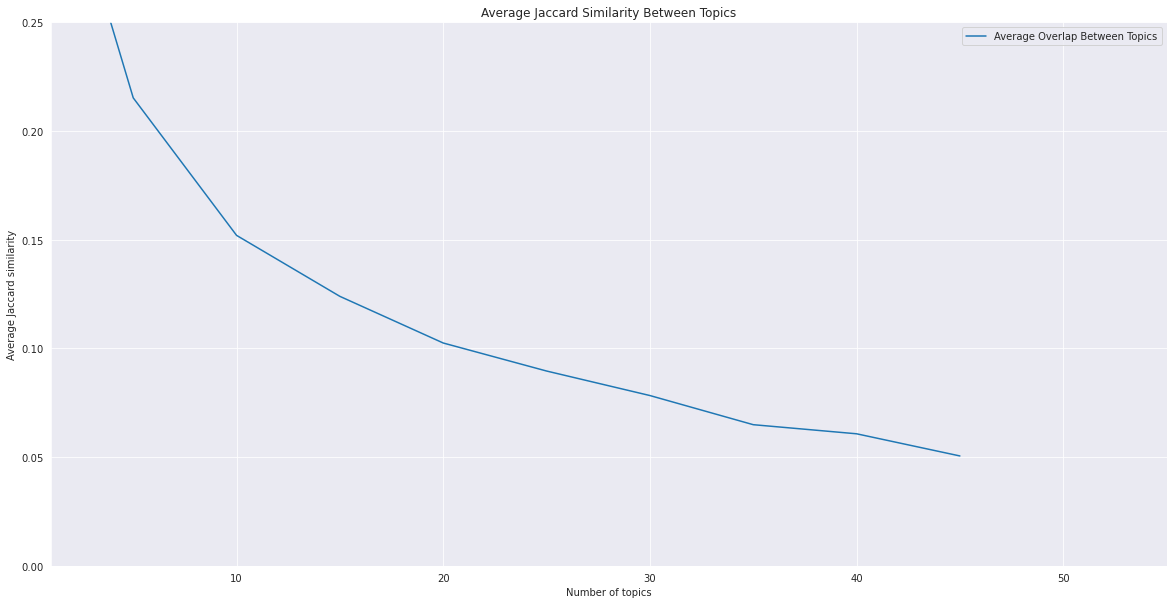

In [47]:
lda_stability = pickle.load(open(project_folder+'/models6/pub_lda_bow_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.figure(figsize=(20,10))
    plt.plot(x,y,label='Average Overlap Between Topics')
    plt.xlim([1, 55])
    plt.ylim([0, 0.25])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')   
    plt.title('Average Jaccard Similarity Between Topics')
    plt.legend()    
    plt.show()

# 4. Model 선택

Topic 선택 threshold : minimum_probability (float, optional) – Topics with a probability lower than this threshold will be filtered out.

#### Coherence score가 높아지고, Perpelxity score가 낮은 35개의 topic 을 선택한다.

In [70]:
num_topics = 35
lda_model_final = models.LdaModel.load(project_folder+'/models6/ldamodels_bow_'+str(num_topics)+'.lda')

In [68]:
# 토픽별 포함된 단어 표시
from pprint import pprint
top_topics = lda_model_final.top_topics(corpus, topn=10)

avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

counter = 0
for topic in top_topics[:5]:
    print('Topic {}:'.format(counter))
    counter += 1
    pprint(topic)
    
pickle.dump(lda_topics,open(project_folder+'/models6/pub_lda_bow_topics.pkl','wb'))

Average topic coherence: -1.3565.
Topic 0:
([(0.028029878, '처방'),
  (0.022417061, '증상'),
  (0.017461188, '한방'),
  (0.015395121, '생각'),
  (0.013712564, '치료'),
  (0.013494522, '의학'),
  (0.0134670595, '한약'),
  (0.013205063, '사용'),
  (0.012839564, '사람'),
  (0.01267821, '경우')],
 -0.6127859723670805)
Topic 1:
([(0.029167572, '관절'),
  (0.028124547, '치료'),
  (0.026628487, '무릎'),
  (0.022705115, '수술'),
  (0.022166058, '손상'),
  (0.022129524, '통증'),
  (0.020895755, '환자'),
  (0.019677116, '경우'),
  (0.014101438, '운동'),
  (0.013950022, '출처')],
 -0.8282885750199375)
Topic 2:
([(0.059770156, '통증'),
  (0.022834562, '경우'),
  (0.021677252, '증상'),
  (0.01841211, '발생'),
  (0.018058972, '부위'),
  (0.015646731, '염증'),
  (0.012751685, '원인'),
  (0.012164128, '진단'),
  (0.010413871, '질환'),
  (0.010149339, '관절')],
 -0.8688459372741731)
Topic 3:
([(0.01833644, '온병'),
  (0.01575971, '변증'),
  (0.014388867, '기혈'),
  (0.012594788, '사기'),
  (0.010764592, '상한'),
  (0.010434921, '이것'),
  (0.010287928, '경우'),
  (0.00999573

### 각 아티클마다 토픽 배분

In [50]:
corpus_lda_model = lda_model_final[corpus]
for article in corpus_lda_model[0]:
    print(article)

(1, 0.35779223)
(10, 0.017463023)
(14, 0.19861303)
(20, 0.050068643)
(21, 0.064981505)
(22, 0.034152612)
(24, 0.15160364)
(29, 0.115135625)


/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
from operator import itemgetter
index_high_corr_list = []

index_counter = 0

for article in corpus_lda_model:
    highest_feature = max(article, key=itemgetter(1))[0]
    max_correlation = max(article, key=itemgetter(1))[1]
    index_high_corr_list.append([index_counter, highest_feature, max_correlation])
    index_counter += 1

index_high_corr_list[:5]

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[0, 1, 0.35780838],
 [1, 11, 0.36908692],
 [2, 17, 0.6179745],
 [3, 14, 0.80570054],
 [4, 33, 0.5564428]]

## 아티클(책) 별 선택된 주제의 확률값 그래프화

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


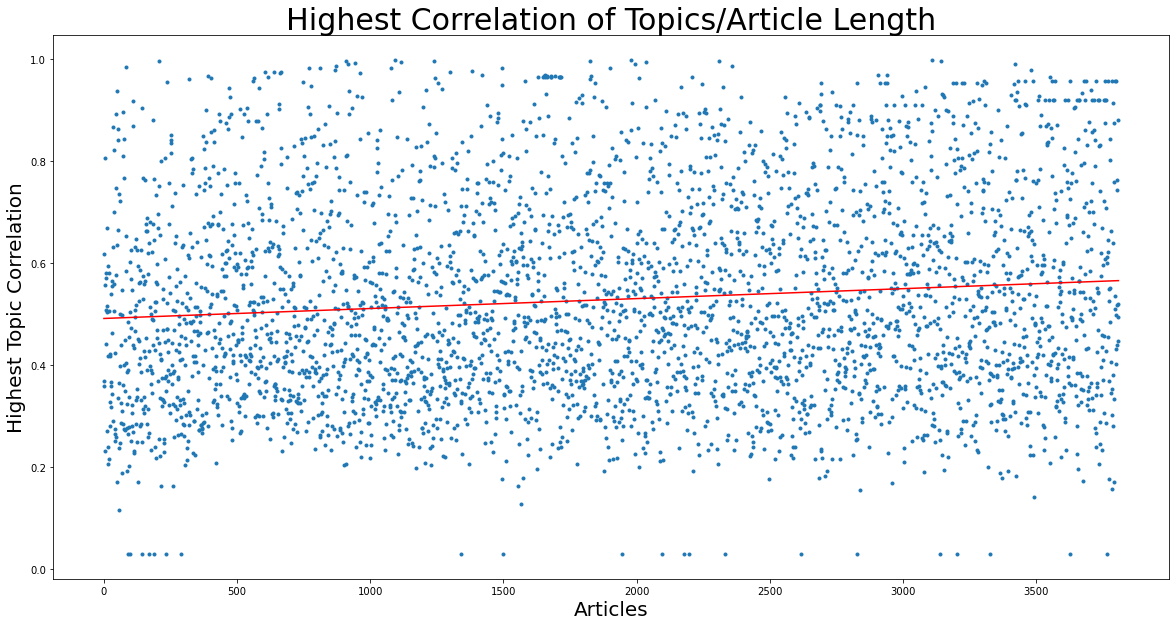

In [53]:
x = [tup[0] for tup in index_high_corr_list]
y = [tup[2] for tup in index_high_corr_list]

plt.figure(figsize=(20,10))
scatter = plt.plot(x,y, '.')
line = plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'r')
plt.title('Highest Correlation of Topics/Article Length', fontsize=30)
plt.xlabel("Articles", fontsize=20)
plt.ylabel("Highest Topic Correlation", fontsize=20)
plt.show(scatter, line)

## 주제별 시각화

In [54]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(lda_model_final, corpus, dictionary)
data

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2      0.119998 -0.157385       1        1  5.963720
17     0.128775 -0.139784       2        1  5.374164
21    -0.169418 -0.021472       3        1  4.969002
18     0.090291 -0.161392       4        1  4.601614
29     0.099648 -0.052758       5        1  4.384746
14    -0.189618 -0.011969       6        1  4.298103
19     0.022061  0.159646       7        1  4.213815
10    -0.206707 -0.059706       8        1  4.029964
31     0.064314 -0.050156       9        1  3.767045
27     0.178302 -0.074741      10        1  3.679253
5      0.149671  0.177885      11        1  3.552035
32     0.137918  0.046745      12        1  3.442140
8      0.091743 -0.038655      13        1  3.391658
24    -0.199083  0.075286      14        1  3.317539
26     0.087457  0.121595      15        1  3.105908
12     0.083297  0.269794      16        1  2.958399
1     -0.082216 -0.134719      17        1  2.914026
30     0.112037 -0.037705      18        1  2.716367
20    -0.131274 -0.070486      19        1  2.635926
3     -0.057717  0.163695      20        1  2.518399
13     0.069669  0.110647      21        1  2.518285
25    -0.137097 -0.006094      22        1  2.409373
0      0.041777 -0.016423      23        1  2.118972
34     0.095969 -0.070126      24        1  2.067406
16     0.046902  0.002468      25        1  1.959149
15     0.103600 -0.053319      26        1  1.913060
6      0.136249 -0.008540      27        1  1.801191
4     -0.029402  0.138474      28        1  1.706824
9     -0.110547 -0.094827      29        1  1.635071
28    -0.125556 -0.066556      30        1  1.483435
23    -0.245071 -0.042929      31        1  1.327213
33     0.116609 -0.104895      32        1  1.318230
22    -0.148774  0.136502      33        1  0.890402
11     0.010740  0.127072      34        1  0.637062
7     -0.154546 -0.055172      35        1  0.380505, topic_info=    Term          Freq         Total Category  logprob  loglift
44    치료  18881.000000  18881.000000  Default  30.0000  30.0000
94    환자  15355.000000  15355.000000  Default  29.0000  29.0000
260   처방   6294.000000   6294.000000  Default  28.0000  28.0000
146   통증   7949.000000   7949.000000  Default  27.0000  27.0000
1     검사   6384.000000   6384.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
10    내용     28.029161   2992.041548  Topic35  -4.8883   0.9010
231   조직     22.362690   1483.139114  Topic35  -5.1142   1.3769
74    소개     21.942883   1311.871185  Topic35  -5.1331   1.4807
88    중요     22.816642   2527.428147  Topic35  -5.0941   0.8640
73    생각     24.092943   5225.479678  Topic35  -5.0396   0.1920

[2547 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1544       7  0.084528   가감
1544      11  0.026895   가감
1544      14  0.069160   가감
1544      15  0.069160   가감
1544      16  0.230532   가감
...      ...       ...  ...
615        6  0.879186   힐링
13877      1  0.041765   힘줄
13877      2  0.786577   힘줄
13877     10  0.163580   힘줄
13877     23  0.003480   힘줄

[14040 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 18, 22, 19, 30, 15, 20, 11, 32, 28, 6, 33, 9, 25, 27, 13, 2, 31, 21, 4, 14, 26, 1, 35, 17, 16, 7, 5, 10, 29, 24, 34, 23, 12, 8])

# 5. Recommender

코사인 유사도 매트릭스 생성

In [55]:
index = similarities.MatrixSimilarity(lda_model_final[corpus])
index[corpus_lda_model].shape

/home/user_1/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3810, 3810)


- 모델 args 설명
    - title: 책 혹은 아티클의 제목을 넣는다. str
    - book: 책을 검색 대상에 넣을 경우 True. booleen
    - article: 아티클을 검색 대상에 넣을 경우 True. booleen
- 동작 원리
    - 1. title에 넣은 아이템의 각 topic들에 대한 확률값 목록을 가져온다.
    - 2. 이 확률값 목록이 가장 비슷한 아이템들을 불러온다.

In [74]:
# argu
def book_recommender_all(title,book=True,article=True):
    books_checked = 0
    for i in range(len(df_des)):
        recommendation_scores = []
        # 넣은 타이틀이 동일할 경우
        if df_des.loc[i,'title'] == title:
            # i 번째 아티클의 topic 확률들 불러오기
            lda_vectors = corpus_lda_model[i]
            # 해당 토픽들간의 similar matrix 값
            sims = index[lda_vectors]
            sims = list(enumerate(sims))
#             print(sims)
            for sim in sims:
                book_num = sim[0]# enumerate index 값
                recommendation_score = [df_des.iloc[book_num,2], sim[1]]
                recommendation_scores.append(recommendation_score)
            
            if (book == True) and (article==True) :
                recommendation = sorted(recommendation_scores, key=lambda x: x[1], reverse=True) # sim score 값에 따라 정렬
                print("Your book's most prominent tokens are:")
                article_tokens = corpus[i] # 해당 문서의 단어 토큰들
                sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True) # 단어 토큰의 빈도로 정렬
                sorted_tokens_10 = sorted_tokens[:10]
                for i in range(len(sorted_tokens_10)):
                    print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                                 dictionary[sorted_tokens_10[i][0]], 
                                                                 sorted_tokens_10[i][1]))
                print('-----')
                print("Your book's most prominant topic is:")
                print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
                print('-----')
                print('Here are your recommendations for "{}":'.format(title))
                display(recommendation[1:11])
        
            elif (book == True) and (article == False) :
                    recommendation = sorted(recommendation_scores[:373], key=lambda x: x[1], reverse=True) # sim score 값에 따라 정렬
                    print("Your book's most prominent tokens are:")
                    article_tokens = corpus[i] # 해당 문서의 단어 토큰들
                    sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True) # 단어 토큰의 빈도로 정렬
                    sorted_tokens_10 = sorted_tokens[:10]
                    for i in range(len(sorted_tokens_10)):
                        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                                     dictionary[sorted_tokens_10[i][0]], 
                                                                     sorted_tokens_10[i][1]))
                    print('-----')
                    print("Your book's most prominant topic is:")
                    print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
                    print('-----')
                    print('Here are your recommendations for "{}":'.format(title))
                    display(recommendation[1:11])                

            elif (book == False) and (article == True) :
                    recommendation = sorted(recommendation_scores[373:], key=lambda x: x[1], reverse=True) # sim score 값에 따라 정렬
                    print("Your book's most prominent tokens are:")
                    article_tokens = corpus[i] # 해당 문서의 단어 토큰들
                    sorted_tokens = sorted(article_tokens, key=lambda x: x[1], reverse=True) # 단어 토큰의 빈도로 정렬
                    sorted_tokens_10 = sorted_tokens[:10]
                    for i in range(len(sorted_tokens_10)):
                        print("Word {} (\"{}\") appears {} time(s).".format(sorted_tokens_10[i][0], 
                                                                     dictionary[sorted_tokens_10[i][0]], 
                                                                     sorted_tokens_10[i][1]))
                    print('-----')
                    print("Your book's most prominant topic is:")
                    print(lda_model_final.print_topic(max(lda_vectors, key=lambda item: item[1])[0]))
                    print('-----')
                    print('Here are your recommendations for "{}":'.format(title))
                    display(recommendation[1:11])                
            else :
                print("sorry, you should select either book or article or both")
        else:
            books_checked +=1
        
        # 만약 for문을 다돌았는데 못찾았을 경우
        if books_checked == len(df_des): 
            book_suggestions = []
            print('Sorry, but it looks like "{}" is not available.'.format(title))


In [77]:
book_recommender_all("우리 아이 감기",book=False,article=True)

Your book's most prominent tokens are:
Word 54 ("감기") appears 27 time(s).
Word 75 ("소아") appears 12 time(s).
Word 80 ("원장") appears 11 time(s).
Word 44 ("치료") appears 10 time(s).
Word 36 ("진료") appears 9 time(s).
Word 63 ("기침") appears 9 time(s).
Word 76 ("아이") appears 9 time(s).
Word 229 ("자연") appears 8 time(s).
Word 1546 ("경과") appears 8 time(s).
Word 48 ("필요") appears 7 time(s).
-----
Your book's most prominant topic is:
0.118*"감기" + 0.074*"아이" + 0.047*"소아" + 0.038*"발열" + 0.029*"기침" + 0.022*"엄마" + 0.016*"의사" + 0.014*"진찰" + 0.013*"감염" + 0.013*"생각"
-----
Here are your recommendations for "우리 아이 감기":


[['감기의 정의', 0.8658896],
 ['감기의 자연경과', 0.82729846],
 ['소아 의료를 바꿔 나갑시다', 0.8087144],
 ['아이의 관점으로 보겠습니다', 0.8068432],
 ['감기와 항생제', 0.79034966],
 ['열도 없고 콧물도 없는데 기침과 노란 가래가 있는 14년생 여아 처방을 어떤식으로 쓰면 좋을까요?', 0.70475274],
 ['[신향화의 핵심 소아과 상식] 0. 프롤로그 - 한의사에게 소아과 지식이 필요한 이유', 0.6784098],
 ['보수교육 초과평점 다음해에 쓸 수 있나요?', 0.6601337],
 ['수유 중인 산무에게서 유두 짓무름이 발생하면 어떻게 치료해야 할까?', 0.64552534],
 ['영유아 아토피 이유식을 어떻게 안내해야 할까요?', 0.6317518]]

In [ ]:
###########################################################################################################

In [ ]:
# !pip install pyldavis==3.2.1